# High-resolution image generation with Segmind-VegaRT and OpenVINO

The [Segmind Vega](https://huggingface.co/segmind/Segmind-Vega) Model is a distilled version of the [Stable Diffusion XL (SDXL)](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0), offering a remarkable 70% reduction in size and an impressive speedup while retaining high-quality text-to-image generation capabilities. Segmind Vega marks a significant milestone in the realm of text-to-image models, setting new standards for efficiency and speed. Engineered with a compact yet powerful design, it boasts only 745 million parameters. This streamlined architecture not only makes it the smallest in its class but also ensures lightning-fast performance, surpassing the capabilities of its predecessors. Vega represents a breakthrough in model optimization. Its compact size, compared to the 859 million parameters of the SD 1.5 and the hefty 2.6 billion parameters of SDXL, maintains a commendable balance between size and performance. Vega's ability to deliver high-quality images rapidly makes it a game-changer in the field, offering an unparalleled blend of speed, efficiency, and precision.

Segmind Vega is a symmetrical, distilled version of the SDXL model; it is over 70% smaller and ~100% faster. The Down Block contains 247 million parameters, the Mid Block has 31 million, and the Up Block has 460 million. Apart from the size difference, the architecture is virtually identical to that of SDXL, ensuring compatibility with existing interfaces requiring no or minimal adjustments. Although smaller than the SD1.5 Model, Vega supports higher-resolution generation due to the SDXL architecture, making it an ideal replacement for [Stable Diffusion 1.5](https://huggingface.co/runwayml/stable-diffusion-v1-5)

Segmind VegaRT is a distilled LCM-LoRA adapter for the Vega model, that allowed us to reduce the number of inference steps required to generate a good quality image to somewhere between 2 - 8 steps. Latent Consistency Model (LCM) LoRA was proposed in [LCM-LoRA: A universal Stable-Diffusion Acceleration Module](https://arxiv.org/abs/2311.05556) by Simian Luo, Yiqin Tan, Suraj Patil, Daniel Gu et al.

More details about models can be found in [Segmind blog post](https://blog.segmind.com/segmind-vega/)

In this tutorial, we explore how to run and optimize Segmind-VegaRT with OpenVINO. We will use a pre-trained model from the [Hugging Face Diffusers](https://huggingface.co/docs/diffusers/index) library. To simplify the user experience, the [Hugging Face Optimum Intel](https://huggingface.co/docs/optimum/intel/index) library is used to convert the models to OpenVINO™ IR format. Additionally, we demonstrate how to improve pipeline latency with the quantization UNet model using [NNCF](https://github.com/openvinotoolkit/nncf).




#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Prepare PyTorch model](#Prepare-PyTorch-model)
- [Convert model to OpenVINO format](#Convert-model-to-OpenVINO-format)
- [Text-to-image generation](#Text-to-image-generation)
    - [Select inference device for text-to-image generation](#Select-inference-device-for-text-to-image-generation)
- [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run quantization](#Run-quantization)
        - [Compare UNet file size](#Compare-UNet-file-size)
    - [Compare the inference time of the FP16 and INT8 models](#Compare-the-inference-time-of-the-FP16-and-INT8-models)
- [Interactive Demo](#Interactive-Demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/stable-diffusion-xl/segmind-vegart.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu\
"torch>=2.1" transformers "diffusers>=0.24.0" "git+https://github.com/huggingface/optimum-intel.git" "gradio>=4.19" "openvino>=2023.3.0" "peft>=0.6.2"

## Prepare PyTorch model
[back to top ⬆️](#Table-of-contents:)


For preparing Segmind-VegaRT model for inference, we should create Segmind-Vega pipeline first. After that, for enabling Latent Consistency Model capability, we should integrate VegaRT LCM adapter using `add_lora_weights` method and replace scheduler with LCMScheduler.
For simplification of these steps for next notebook running, we save created pipeline on disk.

In [ ]:
import torch
from diffusers import LCMScheduler, AutoPipelineForText2Image
import gc
from pathlib import Path

model_id = "segmind/Segmind-Vega"
adapter_id = "segmind/Segmind-VegaRT"
pt_model_dir = Path("segmind-vegart")

if not pt_model_dir.exists():
    pipe = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
    pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
    pipe.load_lora_weights(adapter_id)
    pipe.fuse_lora()

    pipe.save_pretrained("segmind-vegart")
    del pipe
    gc.collect()

## Convert model to OpenVINO format
[back to top ⬆️](#Table-of-contents:)


We will use optimum-cli interface for exporting it into OpenVINO Intermediate Representation (IR) format.

 Optimum CLI interface for converting models supports export to OpenVINO (supported starting optimum-intel 1.12 version).
General command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for, if not specified, the task will be auto-inferred based on the model. Available tasks depend on the model, as Segmind-Vega uses interface compatible with SDXL, we should be selected `stable-diffusion-xl` 

You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager).

Additionally, you can specify weights compression `--weight-format` for the model compression. Please note, that for INT8/INT4, it is necessary to install nncf.

Full list of supported arguments available via `--help`
For more details and examples of usage, please check [optimum documentation](https://huggingface.co/docs/optimum/intel/inference#export).

For Tiny Autoencoder, we will use `ov.convert_model` function for obtaining `ov.Model` and save it using `ov.save_model`. Model consists of 2 parts that used in pipeline separately:
`vae_encoder` for encoding input image in latent space in image-to-image generation task and `vae_decoder` that responsible for decoding diffusion result back to image format.

In [3]:
from pathlib import Path

model_dir = Path("openvino-segmind-vegart")
sdxl_model_id = "./segmind-vegart"
tae_id = "madebyollin/taesdxl"
skip_convert_model = model_dir.exists()

In [4]:
import torch
import openvino as ov
from diffusers import AutoencoderTiny
import gc


class VAEEncoder(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, sample):
        return self.vae.encode(sample)


class VAEDecoder(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, latent_sample):
        return self.vae.decode(latent_sample)


def convert_tiny_vae(model_id, output_path):
    tiny_vae = AutoencoderTiny.from_pretrained(model_id)
    tiny_vae.eval()
    vae_encoder = VAEEncoder(tiny_vae)
    ov_model = ov.convert_model(vae_encoder, example_input=torch.zeros((1, 3, 512, 512)))
    ov.save_model(ov_model, output_path / "vae_encoder/openvino_model.xml")
    tiny_vae.save_config(output_path / "vae_encoder")
    vae_decoder = VAEDecoder(tiny_vae)
    ov_model = ov.convert_model(vae_decoder, example_input=torch.zeros((1, 4, 64, 64)))
    ov.save_model(ov_model, output_path / "vae_decoder/openvino_model.xml")
    tiny_vae.save_config(output_path / "vae_decoder")
    del tiny_vae
    del ov_model
    gc.collect()


if not skip_convert_model:
    !optimum-cli export openvino --model $sdxl_model_id --task stable-diffusion-xl $model_dir --weight-format fp16
    convert_tiny_vae(tae_id, model_dir)

## Text-to-image generation
[back to top ⬆️](#Table-of-contents:)


Text-to-image generation lets you create images using text description. To start generating images, we need to load models first.
To load an OpenVINO model and run an inference with Optimum and OpenVINO Runtime, you need to replace diffusers `StableDiffusionXLPipeline` with Optimum `OVStableDiffusionXLPipeline`. Pipeline initialization starts with using `from_pretrained` method, where a directory with OpenVINO models should be passed. Additionally, you can specify an inference device. 

For saving time, we will not cover image-to-image generation in this notebook. As we already mentioned, Segmind-Vega is compatible with Stable Diffusion XL pipeline, the steps required to run Stable Diffusion XL inference for image-to-image task were discussed in this [notebook](stable-dffision-xl.ipynb).

### Select inference device for text-to-image generation
[back to top ⬆️](#Table-of-contents:)

In [5]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [6]:
from optimum.intel.openvino import OVStableDiffusionXLPipeline

text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


The config attributes {'interpolation_type': 'linear', 'skip_prk_steps': True, 'use_karras_sigmas': False} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the vae_encoder to AUTO ...
Compiling the text_encoder to AUTO ...


  0%|          | 0/4 [00:00<?, ?it/s]

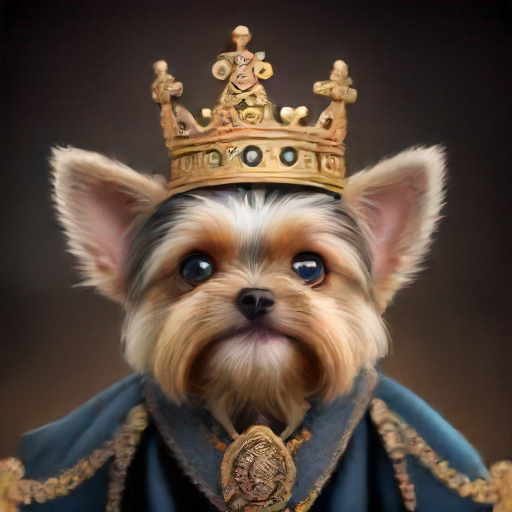

In [7]:
from transformers import set_seed

set_seed(23)

prompt = "A cinematic highly detailed shot of a baby Yorkshire terrier wearing an intricate Italian priest robe, with crown"
image = text2image_pipe(prompt, num_inference_steps=4, height=512, width=512, guidance_scale=0.5).images[0]
image.save("dog.png")
image

In [8]:
del text2image_pipe
gc.collect();

## Quantization
[back to top ⬆️](#Table-of-contents:)


[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `Segmind-VEGAModel` structure, the UNet model takes up significant portion of the overall pipeline execution time. Now we will show you how to optimize the UNet part using [NNCF](https://github.com/openvinotoolkit/nncf/) to reduce computation cost and speed up the pipeline. Quantizing the rest of the SDXL pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [9]:
from notebook_utils import quantization_widget

to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

In [10]:
# Fetch `skip_kernel_extension` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

int8_pipe = None

core = ov.Core()


def create_int8_pipe(model_dir, unet_int8_path, device, core, unet_device="CPU"):
    int8_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device, compile=True)
    del int8_pipe.unet.request
    del int8_pipe.unet.model
    gc.collect()
    int8_pipe.unet.model = core.read_model(unet_int8_path)
    int8_pipe.unet.request = core.compile_model(int8_pipe.unet.model, unet_device or device)
    return int8_pipe


if to_quantize.value and "GPU" in device.value:
    to_quantize.value = False
42
%load_ext skip_kernel_extension

### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)


We use a portion of [conceptual_captions](https://huggingface.co/datasets/conceptual_captions) dataset from Hugging Face as calibration data.
To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [11]:
UNET_INT8_OV_PATH = model_dir / "optimized_unet" / "openvino_model.xml"


def disable_progress_bar(pipeline, disable=True):
    if not hasattr(pipeline, "_progress_bar_config"):
        pipeline._progress_bar_config = {"disable": disable}
    else:
        pipeline._progress_bar_config["disable"] = disable

In [12]:
%%skip not $to_quantize.value

import datasets
import numpy as np
from tqdm.notebook import tqdm
from transformers import set_seed
from typing import Any, Dict, List

set_seed(1)

class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model: ov.CompiledModel, data_cache: List[Any] = None):
        super().__init__(compiled_model)
        self.data_cache = data_cache if data_cache else []

    def __call__(self, *args, **kwargs):
        self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)

def collect_calibration_data(pipe, subset_size: int) -> List[Dict]:
    original_unet = pipe.unet.request
    pipe.unet.request = CompiledModelDecorator(original_unet)

    dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True).shuffle(seed=42)
    disable_progress_bar(pipe)

    # Run inference for data collection
    pbar = tqdm(total=subset_size)
    diff = 0
    for batch in dataset:
        prompt = batch["caption"]
        if len(prompt) > pipe.tokenizer.model_max_length:
            continue
        _ = pipe(
            prompt,
            num_inference_steps=1,
            height=512,
            width=512,
            guidance_scale=0.0,
            generator=np.random.RandomState(987)
        )
        collected_subset_size = len(pipe.unet.request.data_cache)
        if collected_subset_size >= subset_size:
            pbar.update(subset_size - pbar.n)
            break
        pbar.update(collected_subset_size - diff)
        diff = collected_subset_size

    calibration_dataset = pipe.unet.request.data_cache
    disable_progress_bar(pipe, disable=False)
    pipe.unet.request = original_unet
    return calibration_dataset

In [13]:
%%skip not $to_quantize.value

if not UNET_INT8_OV_PATH.exists():
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)
    unet_calibration_data = collect_calibration_data(text2image_pipe, subset_size=200)

### Run quantization
[back to top ⬆️](#Table-of-contents:)


Create a quantized model from the pre-trained converted OpenVINO model. Quantization of the first and last `Convolution` layers impacts the generation results. We recommend using `IgnoredScope` to keep accuracy sensitive `Convolution` layers in FP16 precision.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [14]:
%%skip not $to_quantize.value

import nncf
from nncf.scopes import IgnoredScope

UNET_OV_PATH = model_dir / "unet" / "openvino_model.xml"
if not UNET_INT8_OV_PATH.exists():
    unet = core.read_model(UNET_OV_PATH)
    quantized_unet = nncf.quantize(
        model=unet,
        model_type=nncf.ModelType.TRANSFORMER,
        calibration_dataset=nncf.Dataset(unet_calibration_data),
        ignored_scope=IgnoredScope(
            names=[
                "__module.model.conv_in/aten::_convolution/Convolution",
                "__module.model.up_blocks.2.resnets.2.conv_shortcut/aten::_convolution/Convolution",
                "__module.model.conv_out/aten::_convolution/Convolution"
            ],
        ),
    )
    ov.save_model(quantized_unet, UNET_INT8_OV_PATH)

The config attributes {'interpolation_type': 'linear', 'skip_prk_steps': True, 'use_karras_sigmas': False} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the text_encoder to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the vae_encoder to AUTO ...


  0%|          | 0/4 [00:00<?, ?it/s]

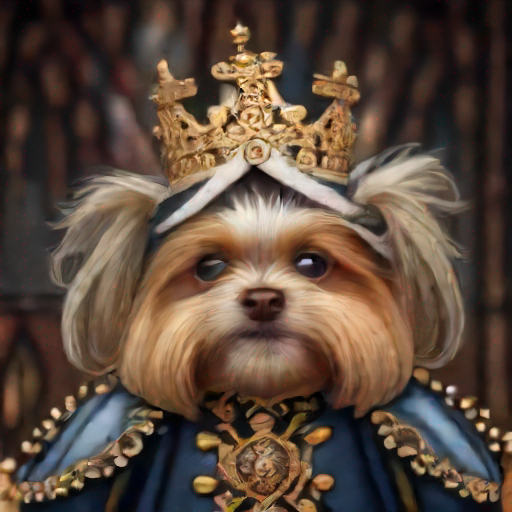

In [15]:
%%skip not $to_quantize.value

int8_text2image_pipe = create_int8_pipe(model_dir, UNET_INT8_OV_PATH, device.value, core)


set_seed(23)
        
image = int8_text2image_pipe(prompt, num_inference_steps=4, height=512, width=512, guidance_scale=0.5).images[0]
display(image)

#### Compare UNet file size
[back to top ⬆️](#Table-of-contents:)

In [16]:
%%skip not $to_quantize.value

fp16_ir_model_size = UNET_OV_PATH.with_suffix(".bin").stat().st_size / 1024
quantized_model_size = UNET_INT8_OV_PATH.with_suffix(".bin").stat().st_size / 1024

print(f"FP16 model size: {fp16_ir_model_size:.2f} KB")
print(f"INT8 model size: {quantized_model_size:.2f} KB")
print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 model size: 1455519.49 KB
INT8 model size: 729448.00 KB
Model compression rate: 1.995


### Compare the inference time of the FP16 and INT8 models
[back to top ⬆️](#Table-of-contents:)


To measure the inference performance of the `FP16` and `INT8` pipelines, we use median inference time on the calibration subset.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [17]:
%%skip not $to_quantize.value

import time

validation_size = 7
calibration_dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True)
validation_data = []
for idx, batch in enumerate(calibration_dataset):
    if idx >= validation_size:
        break
    prompt = batch["caption"]
    validation_data.append(prompt)

def calculate_inference_time(pipe, dataset):
    inference_time = []
    disable_progress_bar(pipe)

    for prompt in dataset:
        start = time.perf_counter()
        image = pipe(
            prompt,
            num_inference_steps=4,
            guidance_scale=1.0,
            generator=np.random.RandomState(23)
        ).images[0]
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    disable_progress_bar(pipe, disable=False)
    return np.median(inference_time)

/home/ea/work/openvino_notebooks/test_env/lib/python3.8/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [18]:
%%skip not $to_quantize.value

int8_latency = calculate_inference_time(int8_text2image_pipe, validation_data)

del int8_text2image_pipe
gc.collect()

text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)
fp_latency = calculate_inference_time(text2image_pipe, validation_data)

del text2image_pipe
gc.collect()
print(f"FP16 pipeline latency: {fp_latency:.3f}")
print(f"INT8 pipeline latency: {int8_latency:.3f}")
print(f"Text-to-Image generation speed up: {fp_latency / int8_latency:.3f}")

The config attributes {'interpolation_type': 'linear', 'skip_prk_steps': True, 'use_karras_sigmas': False} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the text_encoder to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the vae_encoder to AUTO ...


FP16 pipeline latency: 11.029
INT8 pipeline latency: 5.967
Text-to-Image generation speed up: 1.849


## Interactive Demo
[back to top ⬆️](#Table-of-contents:)


Now, you can check model work using own text descriptions. Provide text prompt in the text box and launch generation using Run button. Additionally you can control generation with additional parameters:
* Seed - random seed for initialization
* Steps - number of generation steps
* Height and Width - size of generated image

Please select below whether you would like to use the quantized model to launch the interactive demo.

In [19]:
import ipywidgets as widgets

quantized_model_present = UNET_INT8_OV_PATH.exists()

use_quantized_model = widgets.Checkbox(
    value=quantized_model_present,
    description="Use quantized model",
    disabled=not quantized_model_present,
)

use_quantized_model

Checkbox(value=True, description='Use quantized model')

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-xl/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo_segmind_vegart

if use_quantized_model.value:
    if not quantized_model_present:
        raise RuntimeError("Quantized model not found.")
    text2image_pipe = create_int8_pipe(model_dir, UNET_INT8_OV_PATH, device.value, core)

else:
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)

demo = make_demo_segmind_vegart(text2image_pipe, use_quantized_model)

# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/
# if you want create public link for sharing demo, please add share=True
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)